In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install tensorflow-gpu==2.0.0-beta0

In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


In [0]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

In [0]:
original_path = tf.keras.utils.get_file('garden.jpg', 'https://pbs.twimg.com/media/CkWZwJDWEAA1LSj.jpg')
style_path = tf.keras.utils.get_file('paint.jpg', 'https://previews.123rf.com/images/photographicss/photographicss1707/photographicss170700010/82555009-colorful-of-abstract-expressionism-background.jpg')

In [0]:
def load_img(path_img):
  max_dim = 512
  img = tf.io.read_file(path_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  
  new_shape = tf.cast(shape * scale, tf.int32)
  
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [0]:
def show_img(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  
  plt.imshow(image)
  if title:
    plt.title(title)

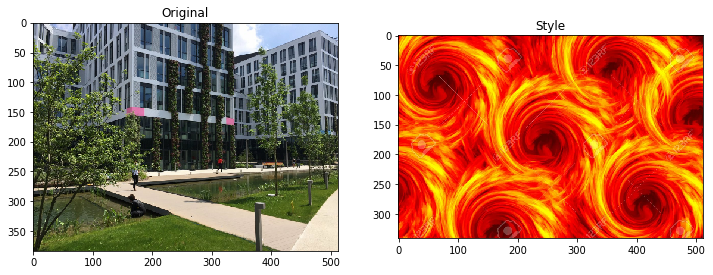

In [32]:
original_img = load_img(original_path)
style_img= load_img(style_path)

plt.subplot(1, 2, 1)
show_img(original_img, 'Original')

plt.subplot(1, 2, 2)
show_img(style_img, 'Style')

In [34]:
x = tf.keras.applications.vgg19.preprocess_input(original_img*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
r = vgg(x)

574717952/574710816 [==============================] - 6s 0us/step


In [35]:
#tf.keras.applications.vgg19.decode_predictions(r.numpy())
labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

print(imagenet_labels[np.argsort(r)[0,::-1][:5]+1])

16384/10484 [==============================================] - 0s 0us/step
['chainlink fence' 'flagpole' 'picket fence' 'worm fence' 'prison']


In [36]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# original layer where will pull our feature maps
original_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_original_layers = len(original_layers)
num_style_layers = len(style_layers)

In [0]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [40]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_img*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 341, 512, 64)
  min:  0.0
  max:  627.7233
  mean:  63.439133

block2_conv1
  shape:  (1, 170, 256, 128)
  min:  0.0
  max:  5419.15
  mean:  237.64384

block3_conv1
  shape:  (1, 85, 128, 256)
  min:  0.0
  max:  9826.329
  mean:  256.79163

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  23026.031
  mean:  819.9911

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3800.8945
  mean:  58.334248



In [0]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [0]:
class StyleOriginalModel(tf.keras.models.Model):
  def __init__(self, style_layers, original_layers):
    super(StyleOriginalModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + original_layers)
    self.style_layers = style_layers
    self.original_layers = original_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, original_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    original_dict = {original_name:value 
                    for original_name, value 
                    in zip(self.original_layers, original_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'original':original_dict, 'style':style_dict}

In [45]:
extractor = StyleOriginalModel(style_layers, original_layers)

results = extractor(tf.constant(original_img))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Originals:")
for name, output in sorted(results['original'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.12139934
    max:  17322.262
    mean:  721.7324

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  197068.02
    mean:  26313.193

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  785374.44
    mean:  25669.836

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  7269943.5
    mean:  354195.9

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  235557.67
    mean:  3067.5486

Originals:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  2049.5142
    mean:  19.950727


In [0]:
style_targets = extractor(style_img)['style']
original_targets = extractor(original_img)['original']

In [0]:
image = tf.Variable(original_img)

In [0]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [0]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
style_weight = 1e-2
original_weight = 1e4

In [0]:
def style_original_loss(outputs):
    style_outputs = outputs['style']
    original_outputs = outputs['original']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    original_loss = tf.add_n([tf.reduce_mean((original_outputs[name]-original_targets[name])**2) 
                             for name in original_outputs.keys()])
    original_loss *= original_weight / num_original_layers
    loss = style_loss + original_loss
    return loss

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_original_loss(outputs)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

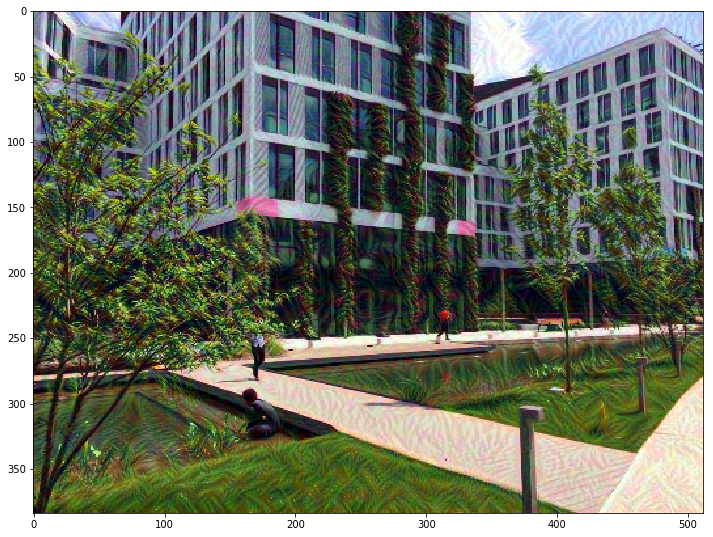

In [57]:
train_step(image)
train_step(image)
train_step(image)
plt.imshow(image.read_value()[0])

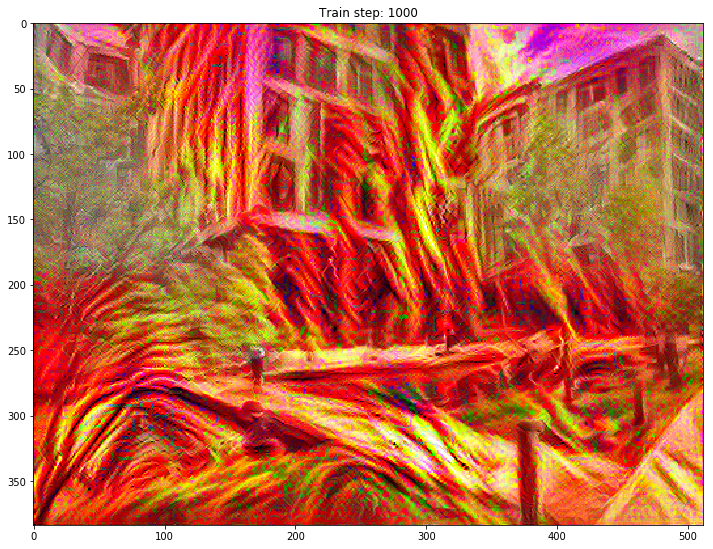

Total time: 76.9


In [59]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  show_img(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

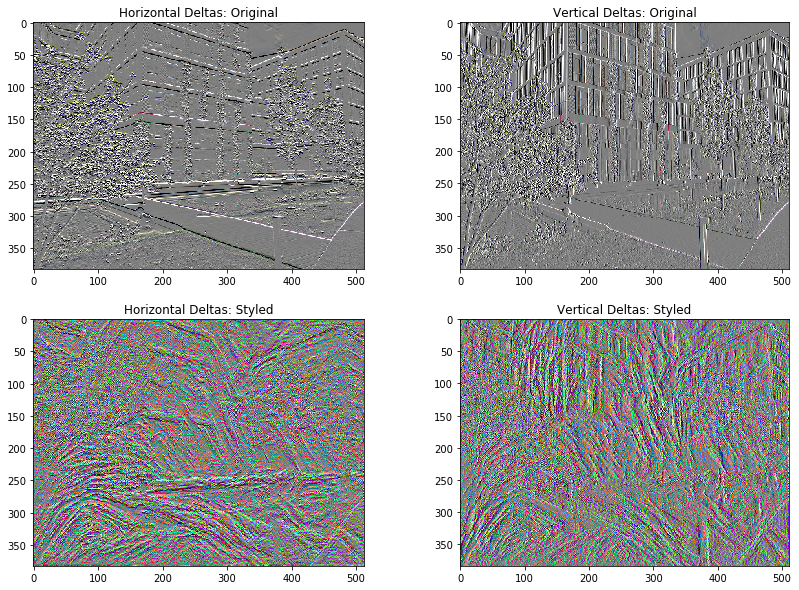

In [62]:
x_deltas, y_deltas = high_pass_x_y(original_img)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
show_img(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
show_img(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
show_img(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
show_img(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

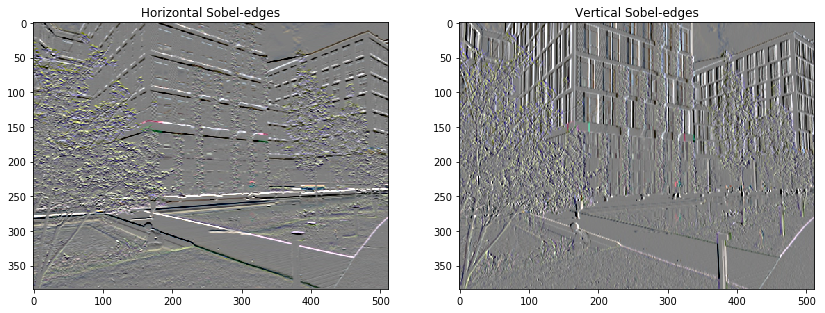

In [63]:
plt.figure(figsize=(14,10))

sobel = tf.image.sobel_edges(original_img)
plt.subplot(1,2,1)
show_img(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
show_img(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [0]:
total_variation_weight = 1e8

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_original_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [0]:
image = tf.Variable(original_img)

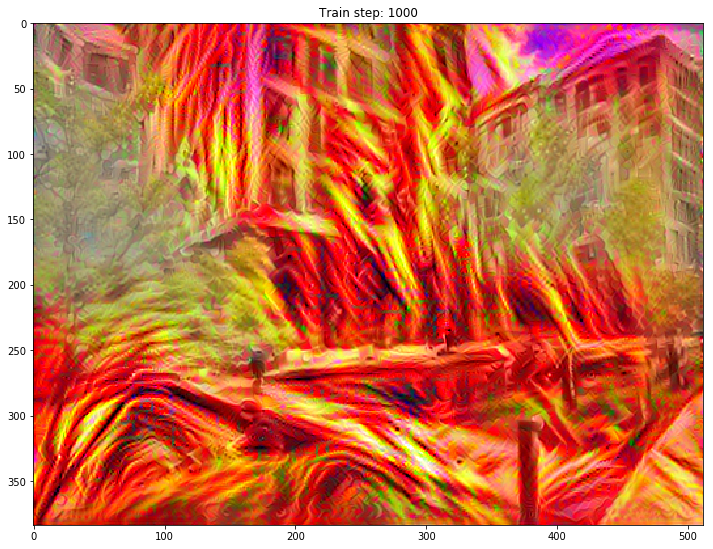

Total time: 80.7


In [73]:
import time
start = time.time()

epochs = 10
steps = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  show_img(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [0]:
from PIL import Image

import matplotlib
file_name = 'neural-garden.jpg'
matplotlib.image.imsave(file_name, image[0])

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(file_name)